## Context

Two time series with recurring data from FRED (Federal Reserve Economic Data) have been selected. On one hand, we have the variable "date," and on the other, the University of Michigan Consumer Sentiment Index. This index is a measure of consumer confidence in the U.S. economy. It is based on surveys that ask consumers about their current perceptions and attitudes towards personal finances, general economic conditions, and intentions to purchase durable goods. High values indicate a higher level of consumer confidence, which is generally considered positive for consumer spending and, therefore, for the economy.

The third variable will be Industrial Production. This series measures the actual output of all facilities in the U.S. manufacturing sector based on the North American Industry Classification System (NAICS). It is an important indicator of economic health, as it reflects the level of activity in factories, mines, and utilities. An increase in industrial production suggests economic growth, while a decrease may indicate an economic contraction.

The goal is to predict future trends using the information from both graphs.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import minmax_scale

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Lambda
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns
import time

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [4]:
seed=42

sns.set_style('whitegrid')
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
results_path = Path('results', 'time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

## 1. Data Loading / Analysis / Preprocessing / Visualization

Throughout the training and evaluation of the models, I have encountered some points that I find interesting regarding the dataset and the approach described in this text. I think it’s worth writing them down and supporting the information with evidence, using different variations of the dataset and strategies for making predictions. I primarily aim to discuss two points:

1. Structure of the Time Series: The time series is defined for the years 1980 to 2023. As seen in the figures displaying the time series, both for the sentiment variable and the ip variable (the latter perhaps being more visibly affected), there are at least two moments when the variable values change drastically. One corresponds to the 2008 financial crisis, and the other to the COVID-19 pandemic in 2020.

We will try to make predictions using data from the last six months for future months close to the year 2020. I believe this impacts the models' ability to predict those months in 2022 and 2023. As we will observe, the loss values for the validation set (val_loss) are consistently higher than those for the training set. The latter is affected by dropout in the recurrent network layers, while the former is not.

When I trained the models for the first time, I found this curious. Upon reviewing the time series, I think the problem may lie in the drastic changes in the series shortly before the values we try to predict—especially for the sentiment variable (which has a major change during COVID-19 and another in 2022), less so for the ip variable. To confirm this, I retrained one of the models (RNNsimple) but using data only up to 2019. I observed that the apparent overfitting issue (which I believe is caused by those drastic changes in the time series, leading to a lack of stable structure between the training and test sets) disappears.

Since addressing the time series structure is not the goal of this text, I won’t delve into this too deeply. However, I find it interesting to note how the models and their generalization capabilities appear to be clearly sensitive to this. To illustrate this point (and although I noticed similar behavior across all models shown here), I will show one example of training and testing with the dataset "trimmed" before 2020 in the RNNsimple network section.

2. Using Two Variables to Train the Model and Predicting Two Variables Simultaneously
The instructions ask us to handle the dataset in a unified way, feeding both variables (sentiment and ip) to the models simultaneously. This means that each instance of input sequences X has a structure of (6,2), and each y instance (i.e., the labels) has a structure of (2).

Initially, I expected that using two variables would be advantageous for the models. However, the results I found with the models required in the instructions are either satisfactory for only one of the two variables or poor for both. Although I’m not entirely certain, I suspect the models may somehow be mixing the information from the two variables. Given that these variables do not fully correlate during the two years we are asked to predict (from May 2022 onward, sentiment tends to increase while ip decreases), the prediction results are generally poor.

To illustrate this point, for the RNNsimple model, I show one version where both variables are trained and predicted simultaneously, along with two additional versions where the models are trained and predictions are made for each variable separately.

In [6]:
# Data loading
df = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '1980', '2023-12').dropna()
df.columns = ['sentiment', 'ip']
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 528 entries, 1980-01-01 to 2023-12-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentiment  528 non-null    float64
 1   ip         528 non-null    float64
dtypes: float64(2)
memory usage: 12.4 KB


,sentiment,ip
DATE,,
1980-01-01,67.0,45.8562
1980-02-01,66.9,46.9435
1980-03-01,56.5,47.5013
1980-04-01,52.7,46.1175
1980-05-01,51.7,44.7997


In [7]:
# Check NAs in "sentiment"
df.loc[df["sentiment"].isnull()==True]

,sentiment,ip
DATE,,


In [8]:
# Check NAs in "ip"
df.loc[df["ip"].isnull()==True]

,sentiment,ip
DATE,,


In [9]:
# Set the number of months for which we want to calculate the difference (1 year)
periods = 12

# Get the logarithm of each value and calculate the 12-month difference
df["diff_log_sentiment"] = np.log(df["sentiment"]).diff(periods=periods)
df["diff_log_ip"] = np.log(df["ip"]).diff(periods=periods)

# Min-max scaling
max_sentiment = df["diff_log_sentiment"].max()
min_sentiment = df["diff_log_sentiment"].min()

max_ip = df["diff_log_ip"].max()
min_ip = df["diff_log_ip"].min()

df["min-max_sentiment"] = (df["diff_log_sentiment"] - min_sentiment) / (max_sentiment - min_sentiment)
df["min-max_ip"] = (df["diff_log_ip"] - min_ip) / (max_ip - min_ip)

In [10]:
df.head(24)

,sentiment,ip,diff_log_sentiment,diff_log_ip,min-max_sentiment,min-max_ip
DATE,,,,,,
1980-01-01,67.0,45.8562,NaN,NaN,NaN,NaN
1980-02-01,66.9,46.9435,NaN,NaN,NaN,NaN
1980-03-01,56.5,47.5013,NaN,NaN,NaN,NaN
1980-04-01,52.7,46.1175,NaN,NaN,NaN,NaN
1980-05-01,51.7,44.7997,NaN,NaN,NaN,NaN
1980-06-01,58.7,44.9905,NaN,NaN,NaN,NaN
1980-07-01,62.3,42.0545,NaN,NaN,NaN,NaN
1980-08-01,67.3,43.5527,NaN,NaN,NaN,NaN
1980-09-01,73.7,45.2613,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'min-max scaling')

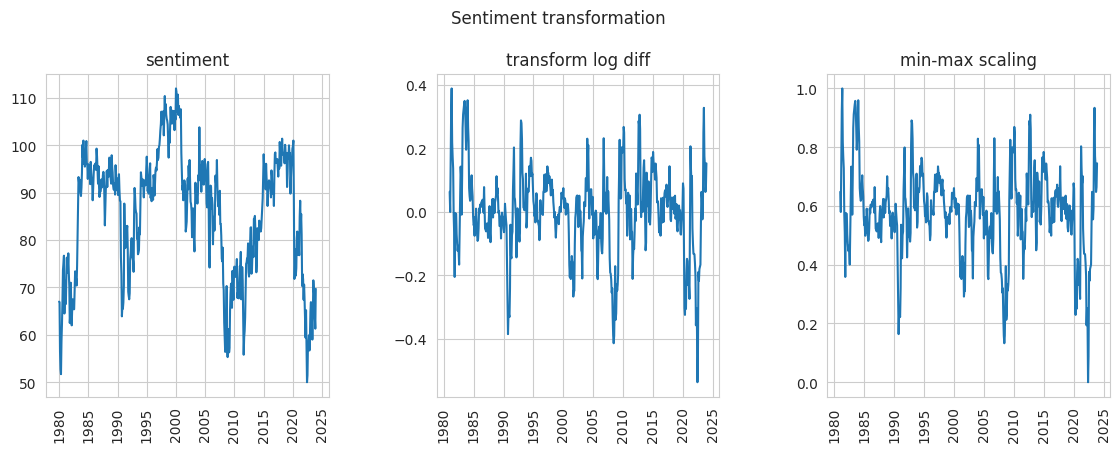

In [11]:
# Show the original "sentiment" time series and its transformations

fig, ax = plt.subplots(1, 3)
fig.suptitle("Sentiment transformation", y=1.05)
fig.tight_layout()
fig.set_size_inches(12, 4)
ax[0].plot(df["sentiment"])
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title("sentiment")

ax[1].plot(df["diff_log_sentiment"])
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title("transform log diff")

ax[2].plot(df["min-max_sentiment"])
ax[2].tick_params(axis='x', rotation=90)
ax[2].set_title("min-max scaling")

Text(0.5, 1.0, 'min-max scaling')

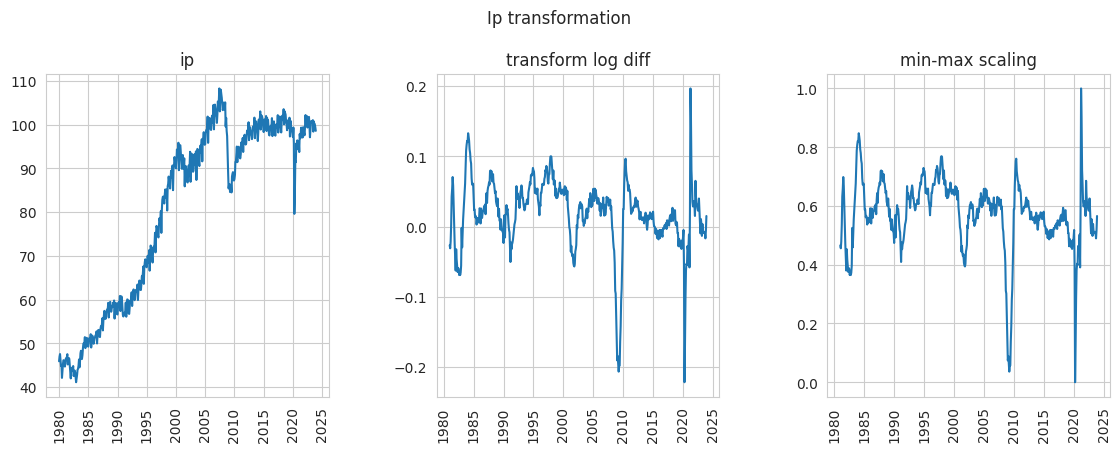

In [12]:
# Show the original "ip" time series and its transformations

fig, ax = plt.subplots(1, 3)
fig.suptitle("Ip transformation", y=1.05)
fig.tight_layout()
fig.set_size_inches(12, 4)
ax[0].plot(df["ip"])
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title("ip")

ax[1].plot(df["diff_log_ip"])
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title("transform log diff")

ax[2].plot(df["min-max_ip"])
ax[2].tick_params(axis='x', rotation=90)
ax[2].set_title("min-max scaling")

In [13]:
# Finally, we keep only the transformed data

# Additionally, since the 12-month difference cannot be applied to the first
# 12 rows (as there is no data prior to 1980), these 12 rows are marked as NaN. Therefore, we remove them.

df = df[["min-max_sentiment", "min-max_ip"]].dropna()

In [14]:
# Show the first 13 months of data
df.head(13)

,min-max_sentiment,min-max_ip
DATE,,
1981-01-01,0.648259,0.465891
1981-02-01,0.579549,0.455921
1981-03-01,0.755588,0.478975
1981-04-01,0.922628,0.535938
1981-05-01,1.000000,0.631726
1981-06-01,0.816544,0.658569
1981-07-01,0.766923,0.698415
1981-08-01,0.727802,0.668894
1981-09-01,0.570718,0.599701


## 2. Data Preparation for Multivariable Model
Once we have preprocessed the data, we will prepare it in the specific format required by a recurrent neural network. To do so, I will:

1. Define and apply a function `create_multivariate_rnn_data`> that transforms the dataset df created above into a format suitable for training a recurrent model. The function should take the dataset and the window size (`window_size`) as input and return a data structure containing the input sequences (X) and target labels (y).
  
2. Use a `window_size` of 6 months to create the X and y datasets and verify the dimensions of the resulting datasets to ensure the transformation was performed correctly.

3. Split the transformed data into training and test sets, using the last 24 months of data as the test set. Besides, I will ensure that both the input data (X_train, X_test) and the labels (y_train, y_test) are correctly partitioned.








In [15]:
# We define the function to split the data and generate the input sequences and target labels.
def create_multivariate_rnn_data(df, window_size):
    """
    For two variables (X and y, both as lists) already created, the function takes a dataframe and a window_size as input.

    For the variable X, the function returns sequences of 6 records (dates) and two variables (sentiment and ip).
    For the variable y, the function returns a single record with two variables corresponding to the record immediately following the last record in each sequence of X:
    
    If we have records 0, 1, 2, 3, 4, 5, 6, 7, 8, and 9, the function will return the variables X and y with the following structure:
    [[0,1,2,3,4,5],
     [1,2,3,4,5,6],
     [2,3,4,5,6,7],
     [3,4,5,6,7,8]]
     
    y:
    [[6],
     [7],
     [8],
     [9]] 
    """
    train=[]
    test=[]
    for el in range(len(df)-window_size):
        train.append(np.array(df.iloc[el:el+window_size]))
        test.append(np.array(df.iloc[el+window_size]))
    return train, test

In [16]:
# Establish the desired window size
window_size = 6

# Vars to store sequences and labels
X = []
y = []

# Call the function to extract the data in the desired format
X, y = create_multivariate_rnn_data(df, window_size)

# Convert the lists to arrays to feed the NN
X = np.array(X)
y = np.array(y)

In [17]:
# Separate training and test sets
# The training set includes all labels except the last 24, as well as the sequences (X) needed to predict those labels.

# The test set includes the last 24 labels, as well as the sequences (X) needed to predict those labels.

X_train = X[0:-24]
X_test = X[-24:]

y_train = y[0:-24]
y_test = y[-24:]

In [18]:
# Check that the split is correct

# As a reference, show the values of the source dataframe between record -30 and -20.
df.tail(30).head(10)

,min-max_sentiment,min-max_ip
DATE,,
2021-07-01,0.701973,0.674225
2021-08-01,0.522680,0.613884
2021-09-01,0.472282,0.598145
2021-10-01,0.437186,0.603521
2021-11-01,0.437106,0.616007
2021-12-01,0.435110,0.600742
2022-01-01,0.404791,0.565950
2022-02-01,0.362148,0.685500
2022-03-01,0.193704,0.633995


The record 2022-01-01 0.404791 0.56594984 corresponds to the 24th, starting from the end. Therefore, this should be the first record of `y_test`

In [19]:
# Check the first record of `y_test`
y_test[0]

array([0.40479131, 0.56594984])

Vemos que el valor es correcto. Además, el registro anterior a este (esto es, 2021-12-01 0.435110 0.60074157) debería ser el último registro de la primera secuencia de `X_test`

In [20]:
X_test[0]

array([[0.70197264, 0.67422499],
       [0.52268033, 0.61388372],
       [0.47228165, 0.59814462],
       [0.43718607, 0.60352084],
       [0.43710574, 0.61600703],
       [0.43510989, 0.60074157]])

Again, the value is correct. Let's continue with the verification. The record 2021-12-01 0.435110 0.60074157 corresponds to the 25th, starting from the end. Therefore, this should be the last record of `y_train`

In [21]:
y_train[-1]

array([0.43510989, 0.60074157])

Again, the value is correct. Finally, the previous record (that is, 2021-11-01 0.437106 0.61600703) should be the last record of the last sequence of `X_train`

In [22]:
X_train[-1]

array([[0.6773403 , 0.72158213],
       [0.70197264, 0.67422499],
       [0.52268033, 0.61388372],
       [0.47228165, 0.59814462],
       [0.43718607, 0.60352084],
       [0.43710574, 0.61600703]])

**The values of `X_train`, `X_test`, `y_train`, and `y_test` are correct, and we can continue with the creation of models.**

## 2.1. Dataset preparation with data up to the end of 2019

As I stated above, I believe the structure of the time series changes drastically during 2020, and this affects the training and predictions for 2022 and 2023. To demonstrate this, I will train and use one of the models (the simple RNN) to predict with a trimmed dataset, such that the years 2018 and 2019 are used as the test set (y_test). I will keep the other parameters unchanged (subtracting the value from 12 months earlier during data transformation, a window_size of 6 units for the input sequences, 24 months in the test set for the labels, etc.).

In [23]:
# Loading data
df_short = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '1980', '2019-12').dropna()
df_short.columns = ['sentiment', 'ip']

# Get the logarithm of each value and calculate the 12-month difference
df_short["diff_log_sentiment"] = np.log(df_short["sentiment"]).diff(periods=periods)
df_short["diff_log_ip"] = np.log(df_short["ip"]).diff(periods=periods)

# Min-max scaling
max_sentiment_short = df_short["diff_log_sentiment"].max()
min_sentiment_short = df_short["diff_log_sentiment"].min()

max_ip_short = df_short["diff_log_ip"].max()
min_ip_short = df_short["diff_log_ip"].min()

df_short["min-max_sentiment"] = (df_short["diff_log_sentiment"] - min_sentiment_short) / (max_sentiment_short - min_sentiment_short)
df_short["min-max_ip"] = (df_short["diff_log_ip"] - min_ip_short) / (max_ip_short - min_ip_short)

df_short = df_short[["min-max_sentiment", "min-max_ip"]].dropna()
df_short.tail(13)

,min-max_sentiment,min-max_ip
DATE,,
2018-12-01,0.546036,0.628477
2019-01-01,0.455265,0.623685
2019-02-01,0.439277,0.580760
2019-03-01,0.477847,0.580892
2019-04-01,0.494916,0.525941
2019-05-01,0.540412,0.557055
2019-06-01,0.515251,0.552471
2019-07-01,0.521595,0.525113
2019-08-01,0.429508,0.545406


In [24]:
# Vars to store sequences and labels
X_short = []
y_short = []

# Call the function to extract the data in the desired format
X_short, y_short = create_multivariate_rnn_data(df_short, window_size)

# Convert the lists to arrays to feed the NN
X_short = np.array(X_short)
y_short = np.array(y_short)

# Split in training and test sets
X_train_short = X_short[0:-24]
X_test_short = X_short[-24:]

y_train_short = y_short[0:-24]
y_test_short = y_short[-24:]

## 2.2. Preparation of datasets with data up to the end of 2023, but separating the two variables.

Also, as stated above, I want to explore the differences between training the models with both variables together and training them with the two variables separately. To do this, I will split the dataset into two parts, one for each variable, and I will train three different models for the simple RNN: one using the dataset with both variables combined, and two others, each using the dataset corresponding to a single variable.








In [25]:
# Vars to store sequences and labels for variable "sentiment"
X_sentiment = []
y_sentiment = []

# Vars to store sequences and labels for variable "ip"
X_ip = []
y_ip = []


# Call the function to extract the data in the desired format for var "sentiment"
X_sentiment, y_sentiment = create_multivariate_rnn_data(df["min-max_sentiment"], window_size)

# Call the function to extract the data in the desired format for var "ip"
X_ip, y_ip = create_multivariate_rnn_data(df["min-max_ip"], window_size)


# Convert the lists to arrays to feed the NN
X_sentiment = np.array(X_sentiment)
y_sentiment = np.array(y_sentiment)
X_ip = np.array(X_ip)
y_ip = np.array(y_ip)


# Split in training and test sets, var "sentiment"
X_train_sentiment = X_sentiment[0:-24]
X_test_sentiment = X_sentiment[-24:]

y_train_sentiment = y_sentiment[0:-24]
y_test_sentiment = y_sentiment[-24:]

# Split in training and test sets, var "ip"
X_train_ip = X_ip[0:-24]
X_test_ip = X_ip[-24:]

y_train_ip = y_ip[0:-24]
y_test_ip = y_ip[-24:]


In [26]:
# Show the structure of the resulting datasets for the var "sentiment"
print(X_train_sentiment.shape)
print(y_train_sentiment.shape)
print(X_test_sentiment.shape)
print(y_test_sentiment.shape)

(486, 6)
(486,)
(24, 6)
(24,)


In [27]:
# Show the structure of the resulting datasets for the var "ip"
print(X_train_ip.shape)
print(y_train_ip.shape)
print(X_test_ip.shape)
print(y_test_ip.shape)

(486, 6)
(486,)
(24, 6)
(24,)


## 3. RNN

Fist, I will build a RNN following the architecture described below:

1. I will add a SimpleRNN layer with a dropout rate of 0.1 for regularization to prevent overfitting. It is important to ensure that the RNN layer is configured not to return sequences, enabling a direct connection to the subsequent dense layers.

2. Set the number of input features (n_features) and the output size (output_size) of the model, both fixed at 2, corresponding to the two time series to be modeled.

3. onfigure the network's hyperparameters, including the number of units in the RNN layer (rnn_units=12) and the number of units in the dense layer (dense_units=6).

4. Include a dense layer with 'relu' activation followed by an output layer with 'linear' activation, suitable for regression tasks such as time series prediction.

5. Compile the model using 'RMSProp' as the optimizer and 'mae' (mean absolute error) as the loss function. This configuration is typically effective for regression problems where minimizing the absolute difference between predicted and actual values is the goal.

   


    
<strong>First, the model is presented using the complete dataset (up to December 2023) and leveraging both variables simultaneously for training and prediction.</strong>

In [28]:
K.clear_session()

# Input and output for all models with two variables
n_features = output_size = 2

# Define model
model_RNN_simple = Sequential()
model_RNN_simple.add(tf.keras.layers.Input(shape=(window_size,n_features)))
model_RNN_simple.add(tf.keras.layers.SimpleRNN(units=12, dropout=0.1, return_sequences=False))
model_RNN_simple.add(tf.keras.layers.Dense(units=6, activation="relu"))
model_RNN_simple.add(tf.keras.layers.Dense(units=output_size, activation="linear"))

In [29]:
# Compile the model
model_RNN_simple.compile(optimizer="RMSProp", loss="mae")
model_RNN_simple.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 12)             │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 272 (1.06 KB)

 Trainable params: 272 (1.06 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
start = time.time()
# Training

# Callback for Early stopping
early_stopping_model_RNN_simple = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10)

# Callback for Model checkpoint
checkpoint_filepath = Path(results_path, 'rnn.h5.keras')

model_checkpoint_model_RNN_simple = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_loss",
    save_best_only=True)

# Train the model
history_model_RNN_simple = model_RNN_simple.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=20,
    callbacks=[early_stopping_model_RNN_simple, model_checkpoint_model_RNN_simple],
    shuffle=False,
    validation_data=(X_test, y_test))

print("Training time: "+str(time.time()-start)+" seconds")

Epoch 1/100


I0000 00:00:1734263896.574193      92 service.cc:145] XLA service 0x5d2a40078250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734263896.574247      92 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/25 ━━━━━━━━━━━━━━━━━━━━ 1:01 3s/step - loss: 0.2379

I0000 00:00:1734263898.214835      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.1723 - val_loss: 0.1594
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1174 - val_loss: 0.1299
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1039 - val_loss: 0.1211
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1027 - val_loss: 0.1175
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1014 - val_loss: 0.1174
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0978 - val_loss: 0.1141
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0943 - val_loss: 0.1128
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0914 - val_loss: 0.1141
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0916 - val_loss: 0.1142
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0902 - val_loss: 0.1167
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0865 - val_loss: 0.1182
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0846 - val_l

In [31]:
# Function to display the loss curve for training and evaluation
def loss_acc_plot(history, title=""):
    fig, ax = plt.subplots(1,1)
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title('Loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(['Training', 'Validation'], loc='upper right')
    fig.tight_layout()
    fig.suptitle(title, x=0.5, y=1.02)
    plt.show()

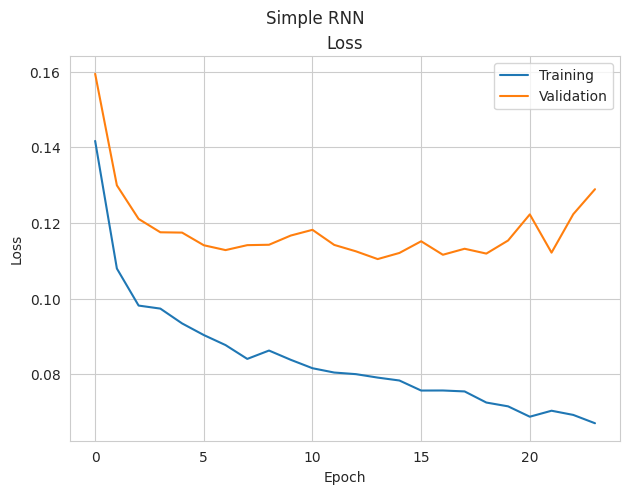

In [32]:
# Show training and validation curves
loss_acc_plot(history_model_RNN_simple,"Simple RNN")

We observe that the loss for the test set is significantly higher than for the training set, especially in the later epochs. As we will see further below, this apparent overfitting could be due to the fact that the structure of the time series changes drastically in 2020 and 2021, coinciding with the Covid pandemic.

In [33]:
# Predict 
predict_RNN_simple = model_RNN_simple.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


In [34]:
# Subset the last 24 rows of the dataset
df_test = df.iloc[-24:]

# Add the predictions from the simple RNN
df_test["RNN_simple_sentiment"] = predict_RNN_simple[:,0]
df_test["RNN_simple_ip"] = predict_RNN_simple[:,1]

In [35]:
# Show the result
df_test

,min-max_sentiment,min-max_ip,RNN_simple_sentiment,RNN_simple_ip
DATE,,,,
2022-01-01,0.404791,0.565950,0.483192,0.499924
2022-02-01,0.362148,0.685500,0.467244,0.479429
2022-03-01,0.193704,0.633995,0.483833,0.499932
2022-04-01,0.251929,0.609546,0.502169,0.498276
2022-05-01,0.201115,0.604075,0.468449,0.512307
2022-06-01,0.000000,0.591963,0.447714,0.471622
2022-07-01,0.087673,0.584146,0.497694,0.452134
2022-08-01,0.375504,0.586329,0.479375,0.472757
2022-09-01,0.345154,0.625328,0.439012,0.519779


Text(0.5, 1.08, 'Real and predicted values, simple RNN')

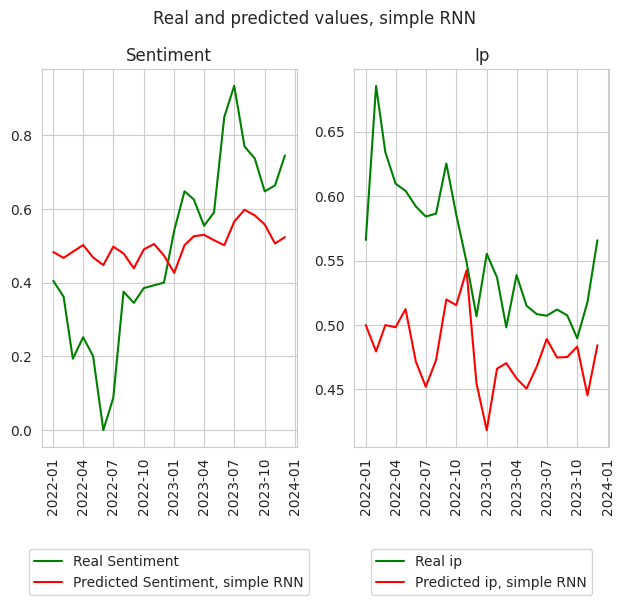

In [36]:
# Show the graphs
fig, ax = plt.subplots(1,2)
fig.tight_layout()
ax[0].plot(df_test["min-max_sentiment"], color="green", label="Real Sentiment")
ax[0].plot(df_test["RNN_simple_sentiment"], color="red", label="Predicted Sentiment, simple RNN")
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title("Sentiment")
box0 = ax[0].get_position()
ax[0].set_position([box0.x0, box0.y0 + box0.height * 0.1,
                    box0.width, box0.height * 0.9])
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

ax[1].plot(df_test["min-max_ip"], color="green", label="Real ip")
ax[1].plot(df_test["RNN_simple_ip"], color="red", label="Predicted ip, simple RNN")
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title("Ip")
box1 = ax[1].get_position()
ax[1].set_position([box1.x0, box1.y0 + box1.height * 0.1,
                    box1.width, box1.height * 0.9])
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

fig.suptitle("Real and predicted values, simple RNN", y=1.08)

We observe that the predictions are quite poor and worse for one of the two variables compared to the other. One way to address this issue could be to allow the model to train for more epochs (by increasing the `patience` value in the EarlyStopping callback), even at the risk of incurring more overfitting.

## 3.1. RNN with dataset truncated until 2019

Now we demonstrate what happens when we remove the more "noisy" years caused by Covid and truncate the dataset to end in 2019. An equivalent model to the previous one is trained but using the shortened dataset:

In [37]:
K.clear_session()

# Input and output for all models with two variables
n_features = output_size = 2

# Define model
model_RNN_simple_short = Sequential()
model_RNN_simple_short.add(tf.keras.layers.Input(shape=(window_size,n_features)))
model_RNN_simple_short.add(tf.keras.layers.SimpleRNN(units=12, dropout=0.1, return_sequences=False))
model_RNN_simple_short.add(tf.keras.layers.Dense(units=6, activation="relu"))
model_RNN_simple_short.add(tf.keras.layers.Dense(units=output_size, activation="linear"))

# Compile
model_RNN_simple_short.compile(optimizer="RMSProp", loss="mae")
model_RNN_simple_short.summary()

start = time.time()
# Training

# Callback for Early stopping
early_stopping_model_RNN_simple_short = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10)

# Model training
history_model_RNN_simple_short = model_RNN_simple_short.fit(
    x=X_train_short,
    y=y_train_short,
    epochs=100,
    batch_size=20,
    callbacks=[early_stopping_model_RNN_simple_short],
    shuffle=False,
    validation_data=(X_test_short, y_test_short))

print("Training time: "+str(time.time()-start)+" seconds")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 12)             │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 272 (1.06 KB)

 Trainable params: 272 (1.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.1559 - val_loss: 0.0441
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1342 - val_loss: 0.0406
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1319 - val_loss: 0.0436
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1244 - val_loss: 0.0426
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1117 - val_loss: 0.0399
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1086 - val_loss: 0.0381
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1010 - val_loss: 0.0361
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0942 - val_loss: 0.0375
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0941 - val_loss: 0.0387
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0884 - val_loss: 0.0393
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0857 - val_loss: 0.0366
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

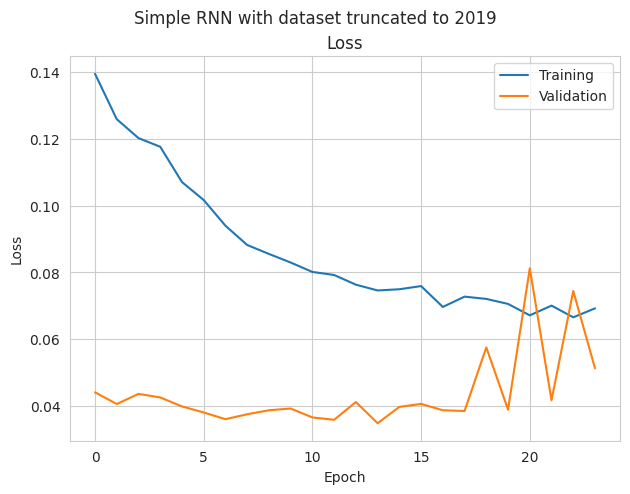

In [38]:
# Show training and validation curves
loss_acc_plot(history_model_RNN_simple_short,"Simple RNN with dataset truncated to 2019")

We observe that the validation curve now clearly falls below the training curve, likely due to the dropout in the SimpleRNN layer, which affects the training loss but not the validation loss. I believe a result like this is what we could expect if the structure of the time series were stable, as is the case when truncating at 2019.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Text(0.5, 1.08, 'Real and predicted values, simple RNN, dataset truncated to 2019')

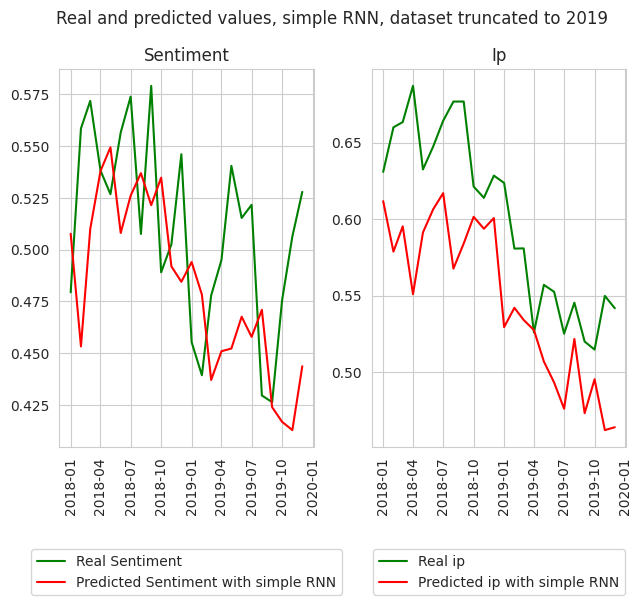

In [39]:
# Predict 
predict_RNN_simple_short = model_RNN_simple_short.predict(X_test_short)

# Subset last 24 rows of the dataset
df_test_short = df_short.iloc[-24:]

# Add the predictions
df_test_short["RNN_simple_sentiment"] = predict_RNN_simple_short[:,0]
df_test_short["RNN_simple_ip"] = predict_RNN_simple_short[:,1]

# Show comparison
fig, ax = plt.subplots(1,2)
fig.tight_layout()
ax[0].plot(df_test_short["min-max_sentiment"], color="green", label="Real Sentiment")
ax[0].plot(df_test_short["RNN_simple_sentiment"], color="red", label="Predicted Sentiment with simple RNN")
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title("Sentiment")
box0 = ax[0].get_position()
ax[0].set_position([box0.x0, box0.y0 + box0.height * 0.1,
                    box0.width, box0.height * 0.9])
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

ax[1].plot(df_test_short["min-max_ip"], color="green", label="Real ip")
ax[1].plot(df_test_short["RNN_simple_ip"], color="red", label="Predicted ip with simple RNN")
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title("Ip")
box1 = ax[1].get_position()
ax[1].set_position([box1.x0, box1.y0 + box1.height * 0.1,
                    box1.width, box1.height * 0.9])
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

fig.suptitle("Real and predicted values, simple RNN, dataset truncated to 2019", y=1.08)

We observe that when we remove the noisiest part at the end of the dataset, the result is much better for at least one of the two variables (though the challenge of training and predicting with two variables simultaneously still remains).

## 3.2. RNN with the complete dataset (up to 2023) but separated by variables

Now let's see if the predictions improve when we split the dataset into two, one for each variable. Once again, we maintain the same structure for the neural network, simply **changing the values for `n_features` and `output_size`**  
First, for the variable Sentiment

In [40]:
K.clear_session()

# Input and output are now 1
n_features = output_size = 1

# Define model
model_RNN_simple_sentiment = Sequential()
model_RNN_simple_sentiment.add(tf.keras.layers.Input(shape=(window_size,n_features)))
model_RNN_simple_sentiment.add(tf.keras.layers.SimpleRNN(units=12, dropout=0.1, return_sequences=False))
model_RNN_simple_sentiment.add(tf.keras.layers.Dense(units=6, activation="relu"))
model_RNN_simple_sentiment.add(tf.keras.layers.Dense(units=output_size, activation="linear"))

# Compile
model_RNN_simple_sentiment.compile(optimizer="RMSProp", loss="mae")
model_RNN_simple_sentiment.summary()

start = time.time()
# Training

# Callback for Early stopping
early_stopping_model_RNN_simple_sentiment = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10)

# Training 
history_model_RNN_simple_sentiment = model_RNN_simple_sentiment.fit(
    x=X_train_sentiment,
    y=y_train_sentiment,
    epochs=100,
    batch_size=20,
    callbacks=[early_stopping_model_RNN_simple_sentiment],
    shuffle=False,
    validation_data=(X_test_sentiment, y_test_sentiment))

print("Training time: "+str(time.time()-start)+" seconds")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 12)             │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253 (1012.00 B)

 Trainable params: 253 (1012.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.4222 - val_loss: 0.1753
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1127 - val_loss: 0.1734
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1173 - val_loss: 0.1726
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1052 - val_loss: 0.1669
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1048 - val_loss: 0.1678
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1052 - val_loss: 0.1670
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1001 - val_loss: 0.1653
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1021 - val_loss: 0.1637
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0962 - val_loss: 0.1598
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0984 - val_loss: 0.1594
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0950 - val_loss: 0.1546
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

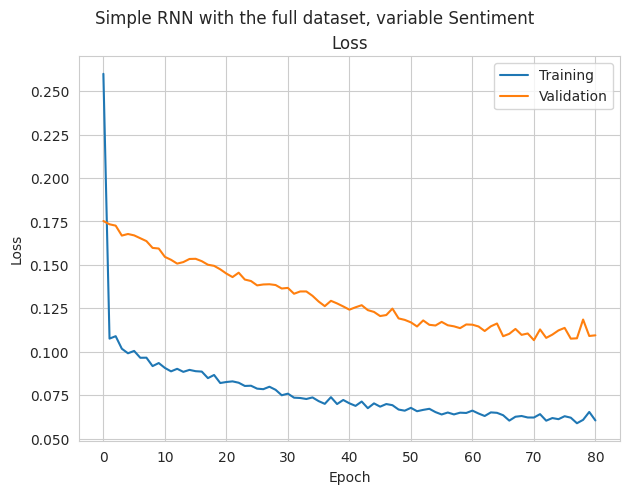

In [41]:
# Show training and validation curves
loss_acc_plot(history_model_RNN_simple_sentiment,"Simple RNN with the full dataset, variable Sentiment")

We again see the loss curve for the validation set significantly above that of the training set, once more because we are using all the data, including the noisiest part of the dataset.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


Text(0.5, 1.08, 'Real and predicted values for the simple RNN for the variable Sentiment')

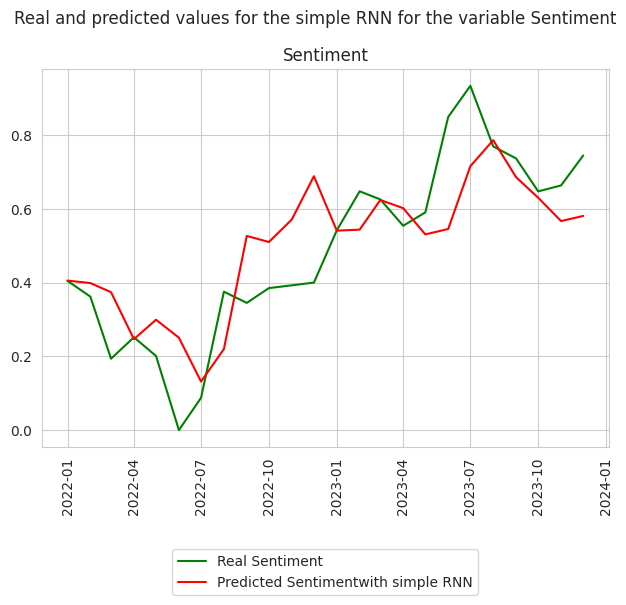

In [42]:
# Predict 
predict_RNN_simple_sentiment = model_RNN_simple_sentiment.predict(X_test_sentiment)

# Subset the last 24 rows of the dataset
df_test_sentiment = df.drop(["min-max_ip"], axis=1).iloc[-24:]

# Add predictions from the simple RNN
df_test_sentiment["RNN_simple_sentiment"] = predict_RNN_simple_sentiment[:,0]

# Show comparison
fig, ax = plt.subplots()
fig.tight_layout()
ax.plot(df_test_sentiment["min-max_sentiment"], color="green", label="Real Sentiment")
ax.plot(df_test_sentiment["RNN_simple_sentiment"], color="red", label="Predicted Sentimentwith simple RNN")
ax.tick_params(axis='x', rotation=90)
ax.set_title("Sentiment")
box0 = ax.get_position()
ax.set_position([box0.x0, box0.y0 + box0.height * 0.1,
                    box0.width, box0.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

fig.suptitle("Real and predicted values for the simple RNN for the variable Sentiment", y=1.08)

We can see that, while not perfect, the prediction for this variable separately is better than for the same variable when attempting to predict both together.

I will now continue with the variable ip.

In [43]:
K.clear_session()

# Input and output are now 1
n_features = output_size = 1

# Define the model
model_RNN_simple_ip = Sequential()
model_RNN_simple_ip.add(tf.keras.layers.Input(shape=(window_size,n_features)))
model_RNN_simple_ip.add(tf.keras.layers.SimpleRNN(units=12, dropout=0.1, return_sequences=False))
model_RNN_simple_ip.add(tf.keras.layers.Dense(units=6, activation="relu"))
model_RNN_simple_ip.add(tf.keras.layers.Dense(units=output_size, activation="linear"))

# Compile
model_RNN_simple_ip.compile(optimizer="RMSProp", loss="mae")
model_RNN_simple_ip.summary()

start = time.time()
# Training

# Callback for Early stopping
early_stopping_model_RNN_simple_ip = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10)

# Training
history_model_RNN_simple_ip = model_RNN_simple_ip.fit(
    x=X_train_ip,
    y=y_train_ip,
    epochs=100,
    batch_size=20,
    callbacks=[early_stopping_model_RNN_simple_ip],
    shuffle=False,
    validation_data=(X_test_ip, y_test_ip))

print("Training time: "+str(time.time()-start)+" seconds")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 12)             │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253 (1012.00 B)

 Trainable params: 253 (1012.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.5919 - val_loss: 0.3135
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2926 - val_loss: 0.0470
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1015 - val_loss: 0.0389
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0950 - val_loss: 0.0390
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0923 - val_loss: 0.0398
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0926 - val_loss: 0.0395
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0899 - val_loss: 0.0398
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0859 - val_loss: 0.0396
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0842 - val_loss: 0.0396
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0858 - val_loss: 0.0397
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0855 - val_loss: 0.0398
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

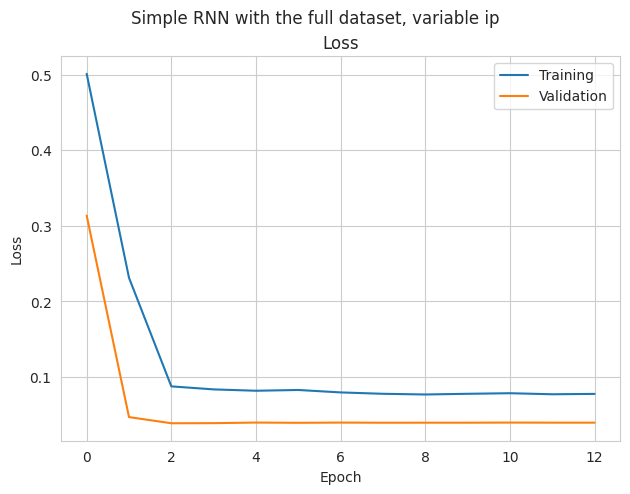

In [44]:
# Show training and validation curves
loss_acc_plot(history_model_RNN_simple_ip,"Simple RNN with the full dataset, variable ip")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Text(0.5, 1.08, 'Real and predicted values for the simple RNN for the variable ip')

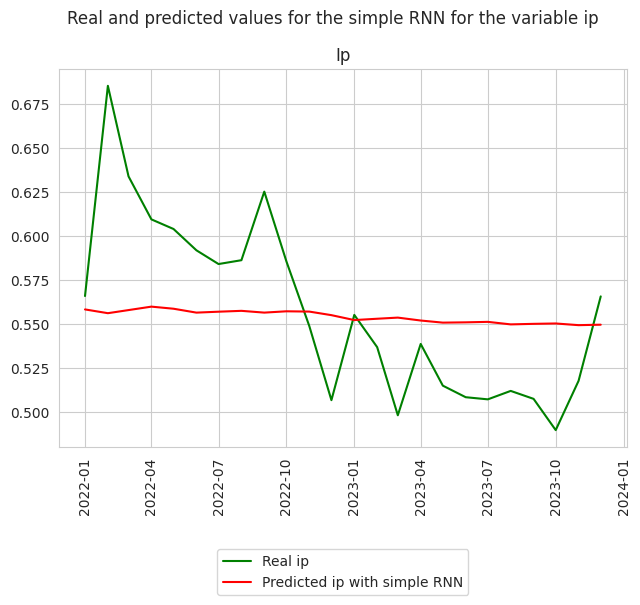

In [45]:
# Predict 
predict_RNN_simple_ip = model_RNN_simple_ip.predict(X_test_ip)

# Subset the last 24 rows of the dataset
df_test_ip = df.drop(["min-max_sentiment"], axis=1).iloc[-24:]

# Add predictions from the simple RNN model
df_test_ip["RNN_simple_ip"] = predict_RNN_simple_ip[:,0]

# Mostrar las gráficas
fig, ax = plt.subplots()
fig.tight_layout()
ax.plot(df_test_ip["min-max_ip"], color="green", label="Real ip")
ax.plot(df_test_ip["RNN_simple_ip"], color="red", label="Predicted ip with simple RNN")
ax.tick_params(axis='x', rotation=90)
ax.set_title("Ip")
box0 = ax.get_position()
ax.set_position([box0.x0, box0.y0 + box0.height * 0.1,
                    box0.width, box0.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

fig.suptitle("Real and predicted values for the simple RNN for the variable ip", y=1.08)

Once again, we have a good prediction compared to what we saw when trying to predict both variables together. A recurring observation is that when training takes more epochs (i.e., early stopping takes longer to trigger), the result tends to be better.








## 3.3. Increasing `patience`

Is there a way to solve this issue? I believe that increasing the value of patience results in better convergence of the models, and the predictions improve when we use the complete dataset (up to 2023) with both variables simultaneously. We could perform a quick test by completely removing the `EarlyStopping` callback.

In [46]:
K.clear_session()

# Input and output for all models with two variables
n_features = output_size = 2

# Define model
model_RNN_simple_more_patience = Sequential()
model_RNN_simple_more_patience.add(tf.keras.layers.Input(shape=(window_size,n_features)))
model_RNN_simple_more_patience.add(tf.keras.layers.SimpleRNN(units=12, dropout=0.1, return_sequences=False))
model_RNN_simple_more_patience.add(tf.keras.layers.Dense(units=6, activation="relu"))
model_RNN_simple_more_patience.add(tf.keras.layers.Dense(units=output_size, activation="linear"))

# Compile
model_RNN_simple_more_patience.compile(optimizer="RMSProp", loss="mae")
model_RNN_simple_more_patience.summary()

start = time.time()

# Training
history_model_RNN_simple_more_patience = model_RNN_simple_more_patience.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=20,
    shuffle=False,
    validation_data=(X_test, y_test))

print("Training time: "+str(time.time()-start)+" seconds")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 12)             │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 272 (1.06 KB)

 Trainable params: 272 (1.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.3802 - val_loss: 0.2169
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1994 - val_loss: 0.1644
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1098 - val_loss: 0.1514
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0965 - val_loss: 0.1422
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0973 - val_loss: 0.1373
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0927 - val_loss: 0.1332
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0923 - val_loss: 0.1281
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0900 - val_loss: 0.1263
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0866 - val_loss: 0.1250
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0888 - val_loss: 0.1230
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0853 - val_loss: 0.1217
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

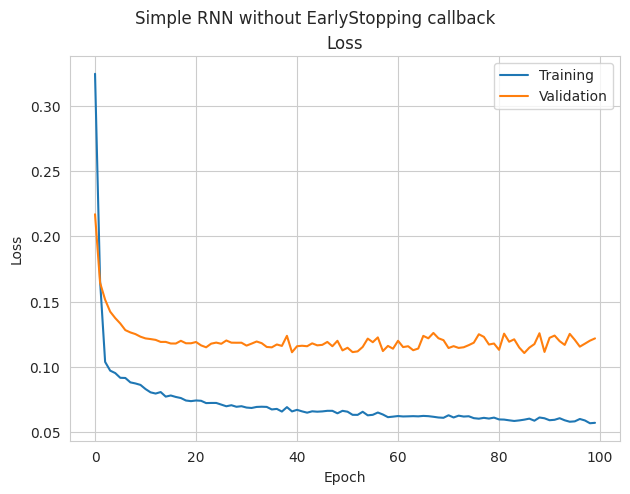

In [47]:
# Show training and validation curves
loss_acc_plot(history_model_RNN_simple_more_patience,"Simple RNN without EarlyStopping callback")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Text(0.5, 1.08, 'Real and predicted values without EarlyStopping callback')

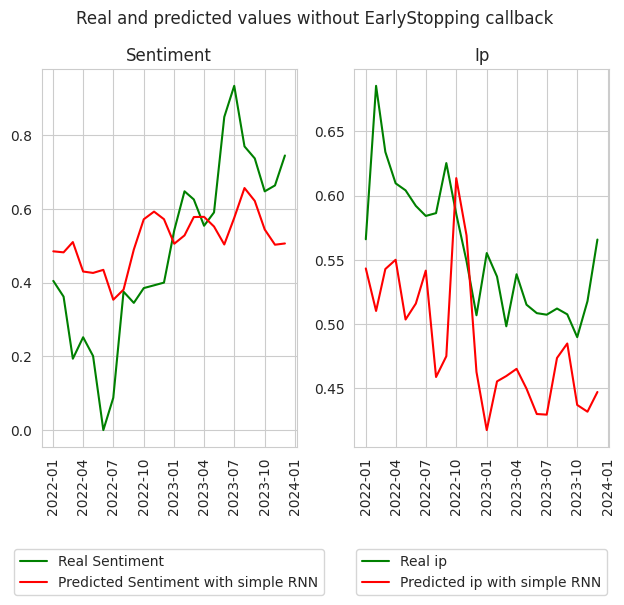

In [48]:
# Predict 
predict_RNN_simple_more_patience = model_RNN_simple_more_patience.predict(X_test)

# Subset the last 24 rows of the dataset
df_test_more_patience = df.iloc[-24:]

# Add predictions from the simple RNN
df_test_more_patience["RNN_simple_sentiment"] = predict_RNN_simple_more_patience[:,0]
df_test_more_patience["RNN_simple_ip"] = predict_RNN_simple_more_patience[:,1]

# Show comparison
fig, ax = plt.subplots(1,2)
fig.tight_layout()
ax[0].plot(df_test_more_patience["min-max_sentiment"], color="green", label="Real Sentiment")
ax[0].plot(df_test_more_patience["RNN_simple_sentiment"], color="red", label="Predicted Sentiment with simple RNN")
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title("Sentiment")
box0 = ax[0].get_position()
ax[0].set_position([box0.x0, box0.y0 + box0.height * 0.1,
                    box0.width, box0.height * 0.9])
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

ax[1].plot(df_test_more_patience["min-max_ip"], color="green", label="Real ip")
ax[1].plot(df_test_more_patience["RNN_simple_ip"], color="red", label="Predicted ip with simple RNN")
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title("Ip")
box1 = ax[1].get_position()
ax[1].set_position([box1.x0, box1.y0 + box1.height * 0.1,
                    box1.width, box1.height * 0.9])
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

fig.suptitle("Real and predicted values without EarlyStopping callback", y=1.08)

We observe that removing the `EarlyStopping` callback improves the result. However, even though only one training instance is shown here, there is significant variability if we repeat the training from scratch multiple times.

## 4. GRU

GRU (Gated Recurrent Unit) is a type of RNN designed to handle sequential data efficiently. It uses two *gates* (reset and update) to control information flow, retaining long-term dependencies while being faster and easier to train. Let's implement a GRU-based NN for our predictions:

In [49]:
K.clear_session()

# Input and output for all models with two variables
n_features = output_size = 2

# Define model
model_GRU = Sequential()
model_GRU.add(tf.keras.layers.Input(shape=(6,n_features)))
model_GRU.add(tf.keras.layers.GRU(units=16, 
                                  dropout=0.1, 
                                  recurrent_dropout=0.1, 
                                  return_sequences=False))
model_GRU.add(tf.keras.layers.Dense(units=8, activation="relu"))
model_GRU.add(tf.keras.layers.Dense(units=output_size, activation="linear"))

In [50]:
# Compile
model_GRU.compile(optimizer="RMSProp", loss="mae")
model_GRU.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 16)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,114 (4.35 KB)

 Trainable params: 1,114 (4.35 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
start = time.time()
# Training

# Callback for Early stopping
early_stopping_model_GRU = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10)

# Callback for Model checkpoint
checkpoint_filepath = Path(results_path, 'gru.h5.keras')

model_checkpoint_model_GRU = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_loss",
    save_best_only=True)

# Entrenar el modelo
history_model_GRU = model_GRU.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=20,
    callbacks=[early_stopping_model_GRU, model_checkpoint_model_GRU],
    shuffle=False,
    validation_data=(X_test, y_test))

print("Training time: "+str(time.time()-start)+" seconds")

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.4917 - val_loss: 0.1484
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1364 - val_loss: 0.1236
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1044 - val_loss: 0.1175
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1062 - val_loss: 0.1115
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1052 - val_loss: 0.1087
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1004 - val_loss: 0.1103
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0948 - val_loss: 0.1079
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1007 - val_loss: 0.1069
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0891 - val_loss: 0.1080
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0991 - val_loss: 0.1065
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0900 - val_loss: 0.1071
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

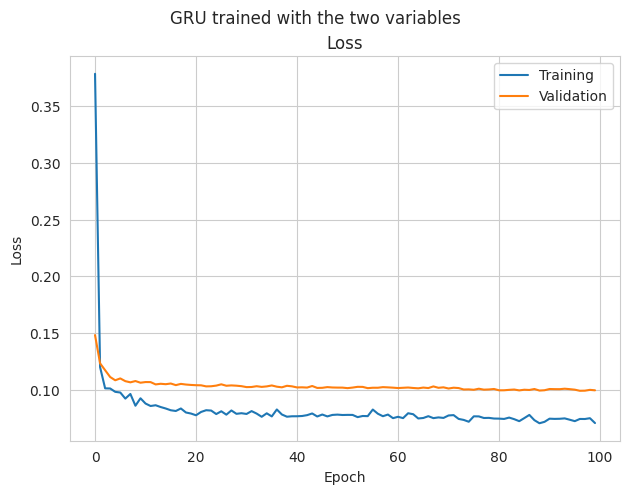

In [52]:
# Training and validation curves
loss_acc_plot(history_model_GRU,"GRU trained with the two variables")

In [53]:
# Predict
predict_GRU = model_GRU.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


In [54]:
# Add predictions of GRU NN
df_test["GRU_sentiment"] = predict_GRU[:,0]
df_test["GRU_ip"] = predict_GRU[:,1]

Text(0.5, 1.08, 'Real and predicted values with GRU')

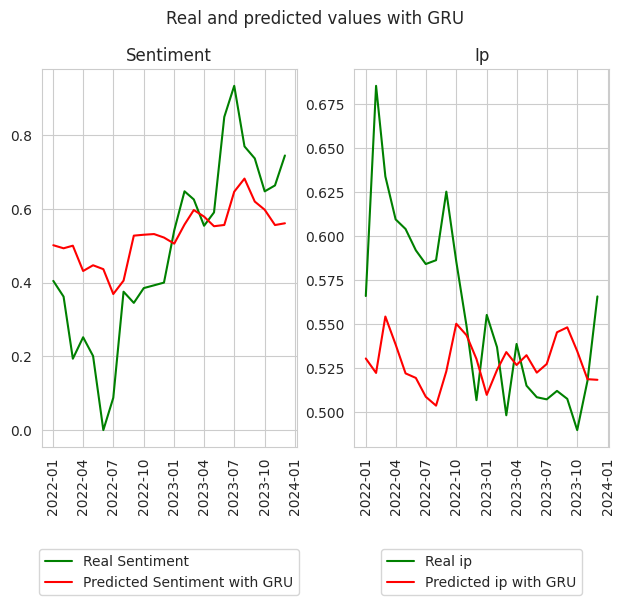

In [55]:
# Show comparison
fig, ax = plt.subplots(1,2)
fig.tight_layout()
ax[0].plot(df_test["min-max_sentiment"], color="green", label="Real Sentiment")
ax[0].plot(df_test["GRU_sentiment"], color="red", label="Predicted Sentiment with GRU")
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title("Sentiment")
box0 = ax[0].get_position()
ax[0].set_position([box0.x0, box0.y0 + box0.height * 0.1,
                    box0.width, box0.height * 0.9])
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

ax[1].plot(df_test["min-max_ip"], color="green", label="Real ip")
ax[1].plot(df_test["GRU_ip"], color="red", label="Predicted ip with GRU")
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title("Ip")
box1 = ax[1].get_position()
ax[1].set_position([box1.x0, box1.y0 + box1.height * 0.1,
                    box1.width, box1.height * 0.9])
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

fig.suptitle("Real and predicted values with GRU", y=1.08)

## 5. LSTM 

LSTM (Long Short-Term Memory) is a type of RNN designed to learn long-term dependencies. It uses three gates (input, forget, and output) to manage information flow, enabling it to retain relevant information over long sequences while filtering out unnecessary details, making it powerful for sequential data tasks. Here the implementation for our dataset:

In [56]:
K.clear_session()

# Input and output for all models with two variables
n_features = output_size = 2

# Define model
model_LSTM = Sequential()
model_LSTM.add(tf.keras.layers.Input(shape=(6,n_features)))
model_LSTM.add(tf.keras.layers.LSTM(units=12, 
                                    dropout=0.1,
                                    recurrent_dropout=0.1,
                                    return_sequences=False))
model_LSTM.add(tf.keras.layers.Dense(units=6, activation="relu"))
model_LSTM.add(tf.keras.layers.Dense(units=output_size, activation="linear"))

In [57]:
# Compile
model_LSTM.compile(optimizer="RMSProp", loss="mae")
model_LSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12)             │           720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 812 (3.17 KB)

 Trainable params: 812 (3.17 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
start = time.time()
# Training

# Callback for Early stopping
early_stopping_model_LSTM = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10)

# Callback for Model checkpoint
checkpoint_filepath = Path(results_path, 'lstm.h5.keras')

model_checkpoint_model_LSTM = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_loss",
    save_best_only=True)

# Training
history_model_LSTM = model_LSTM.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=20,
    callbacks=[early_stopping_model_LSTM, model_checkpoint_model_LSTM],
    shuffle=False,
    validation_data=(X_test, y_test))

print("Training time: "+str(time.time()-start)+" seconds")

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.4058 - val_loss: 0.2062
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1540 - val_loss: 0.1442
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0977 - val_loss: 0.1462
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1018 - val_loss: 0.1458
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0986 - val_loss: 0.1361
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0954 - val_loss: 0.1377
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0899 - val_loss: 0.1377
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0915 - val_loss: 0.1379
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0894 - val_loss: 0.1363
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0875 - val_loss: 0.1305
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0843 - val_loss: 0.1282
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss:

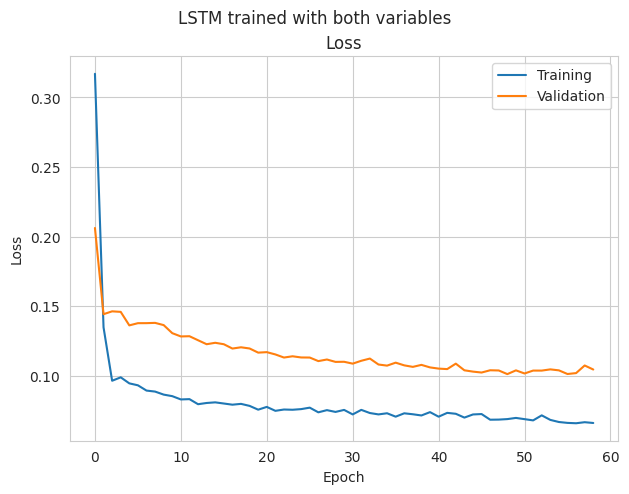

In [59]:
# Show training and validation curves
loss_acc_plot(history_model_LSTM,"LSTM trained with both variables")

In [60]:
# Predict 
predict_LSTM = model_LSTM.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


In [61]:
# Add predictions from LSTM
df_test["LSTM_sentiment"] = predict_LSTM[:,0]
df_test["LSTM_ip"] = predict_LSTM[:,1]

Text(0.5, 1.08, 'Real and predicted values with LSTM')

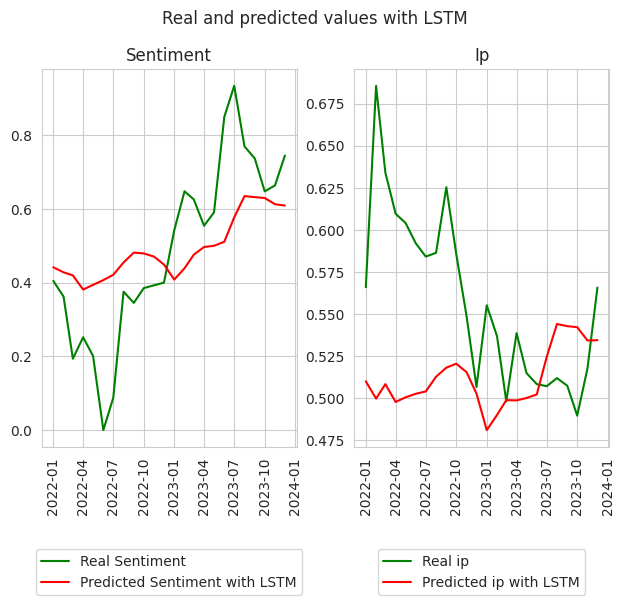

In [62]:
# Show comparison
fig, ax = plt.subplots(1,2)
fig.tight_layout()
ax[0].plot(df_test["min-max_sentiment"], color="green", label="Real Sentiment")
ax[0].plot(df_test["LSTM_sentiment"], color="red", label="Predicted Sentiment with LSTM")
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title("Sentiment")
box0 = ax[0].get_position()
ax[0].set_position([box0.x0, box0.y0 + box0.height * 0.1,
                    box0.width, box0.height * 0.9])
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

ax[1].plot(df_test["min-max_ip"], color="green", label="Real ip")
ax[1].plot(df_test["LSTM_ip"], color="red", label="Predicted ip with LSTM")
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title("Ip")
box1 = ax[1].get_position()
ax[1].set_position([box1.x0, box1.y0 + box1.height * 0.1,
                    box1.width, box1.height * 0.9])
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

fig.suptitle("Real and predicted values with LSTM", y=1.08)

In contrast with expectations, predictions with the LSTM are worse than with the GRU or the simple RNN

## 6. Improved LSTM
In this section, we will aim to enhance the network's capacity by introducing certain improvements that increase the representational ability of the neural network.

One of these improvements will involve using a different type of periodic activation function based on the sine formula, which makes it particularly well-suited for learning representations of data that are intrinsically periodic or cyclical.

The SIREN (SInusoidal REpresentation Networks) activation function is a type of activation function introduced by researchers to enhance the capabilities of neural networks, especially in tasks involving the modeling of periodic phenomena or the handling of higher-order derivatives, as seen in signal processing, image, and audio tasks. The SIREN function uses sine functions as activation functions instead of the traditional ReLU, sigmoid, or tanh functions. The general formula for a SIREN activation function is ϕ(x) = sin(wx + b), where 
w and b are parameters learned during network training.

This activation layer offers smooth and continuous derivatives, which is beneficial for modeling complex relationships in data, including those where higher-order derivatives are significant (such as in physical modeling).

Now, we will expand the standard LSTM architecture by incorporating a Sinusoidal (SIREN) activation function to explore its impact on learning complex temporal dependencies by creating  a `siren_activation` function and applyting it with the LSTM NN.

In [63]:
K.clear_session()
@tf.keras.utils.register_keras_serializable()
def siren_activation(x, w0=2, b=0):
    # Default values for wo and b are stablished at 2 and 0 respectively
    return K.sin(w0*x+b)

In [64]:
K.clear_session()

# Input and output for all models with two variables
n_features = output_size = 2

# Define model
model_LSTM_imp = Sequential()
model_LSTM_imp.add(tf.keras.layers.Input(shape=(6,n_features)))
model_LSTM_imp.add(tf.keras.layers.LSTM(units=24, 
                                        dropout=0.1,
                                        recurrent_dropout=0.1,
                                        return_sequences=False))
model_LSTM_imp.add(tf.keras.layers.Lambda(siren_activation))
model_LSTM_imp.add(tf.keras.layers.Dense(units=12, activation="relu"))
model_LSTM_imp.add(tf.keras.layers.Dense(units=output_size, activation="linear"))

In [65]:
# Compile
model_LSTM_imp.compile(optimizer="RMSProp", loss="mae")
model_LSTM_imp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24)             │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,918 (11.40 KB)

 Trainable params: 2,918 (11.40 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
start = time.time()
# Training

# Callback for Early stopping
early_stopping_model_LSTM_imp = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10)

# Callback for Model checkpoint
checkpoint_filepath = Path(results_path, 'lstm_imp.h5.keras')

model_checkpoint_model_LSTM_imp = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_loss",
    save_best_only=True)

# Entrenar el modelo
history_model_LSTM_imp = model_LSTM_imp.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=20,
    callbacks=[early_stopping_model_LSTM_imp, model_checkpoint_model_LSTM_imp],
    shuffle=False,
    validation_data=(X_test, y_test))

print("Training time: "+str(time.time()-start)+" seconds")

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.2940 - val_loss: 0.1051
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0905 - val_loss: 0.1166
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0904 - val_loss: 0.1085
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0973 - val_loss: 0.0936
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0912 - val_loss: 0.0959
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0914 - val_loss: 0.0942
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0889 - val_loss: 0.0955
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0907 - val_loss: 0.0909
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0868 - val_loss: 0.0936
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0843 - val_loss: 0.0913
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0840 - val_loss: 0.0925
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0

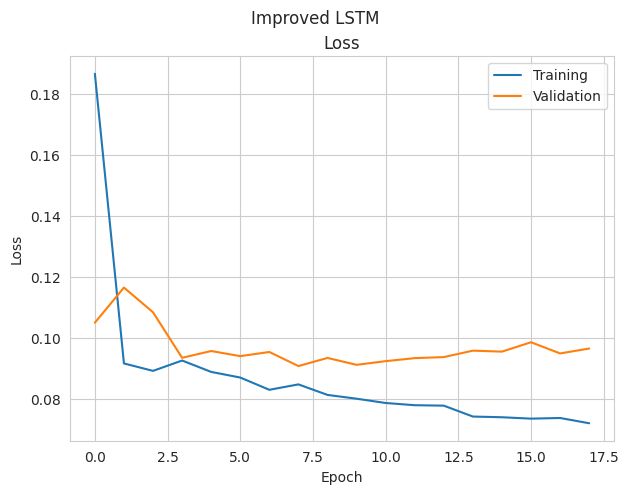

In [67]:
loss_acc_plot(history_model_LSTM_imp, "Improved LSTM")

In [68]:
# Predict 
predict_LSTM_imp = model_LSTM_imp.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


In [69]:
# Add predictions of improved LSTM
df_test["LSTM_imp_sentiment"] = predict_LSTM_imp[:,0]
df_test["LSTM_imp_ip"] = predict_LSTM_imp[:,1]

Text(0.5, 1.08, 'Real and predicted values with improved LSTM')

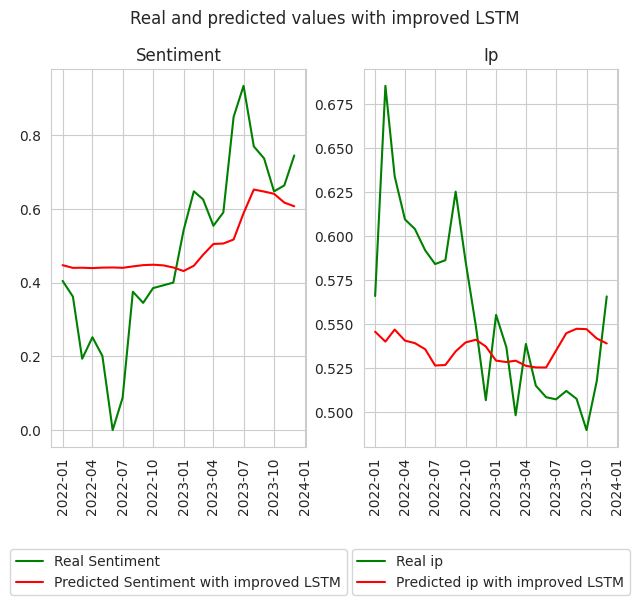

In [70]:
# Show comparison
fig, ax = plt.subplots(1,2)
fig.tight_layout()
ax[0].plot(df_test["min-max_sentiment"], color="green", label="Real Sentiment")
ax[0].plot(df_test["LSTM_imp_sentiment"], color="red", label="Predicted Sentiment with improved LSTM")
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title("Sentiment")
box0 = ax[0].get_position()
ax[0].set_position([box0.x0, box0.y0 + box0.height * 0.1,
                    box0.width, box0.height * 0.9])
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

ax[1].plot(df_test["min-max_ip"], color="green", label="Real ip")
ax[1].plot(df_test["LSTM_imp_ip"], color="red", label="Predicted ip with improved LSTM")
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title("Ip")
box1 = ax[1].get_position()
ax[1].set_position([box1.x0, box1.y0 + box1.height * 0.1,
                    box1.width, box1.height * 0.9])
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

fig.suptitle("Real and predicted values with improved LSTM", y=1.08)

Once again, we have a rather poor prediction, although it improves slightly compared to the LSTM without the lambda layer. Reiterating what we observed with the simple RNN, I want to emphasize the idea that allowing the model to train for more epochs radically improves the results. Since this is the most "advanced" network we will train before hyperparameter tuning, I will once again demonstrate what happens when we train with both variables but without the EarlyStopping callback. I understand that this might lead to more overfitting, but I believe the impact on the prediction quality is evident:

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24)             │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,918 (11.40 KB)

 Trainable params: 2,918 (11.40 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2328 - val_loss: 0.1167
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1038 - val_loss: 0.1175
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1067 - val_loss: 0.1050
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0938 - val_loss: 0.0983
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0961 - val_loss: 0.0962
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0966 - val_loss: 0.0971
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0941 - val_loss: 0.0952
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0945 - val_loss: 0.0965
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0874 - val_loss: 0.0946
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0842 - val_loss: 0.0966
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0826 - val_loss: 0.0932
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0

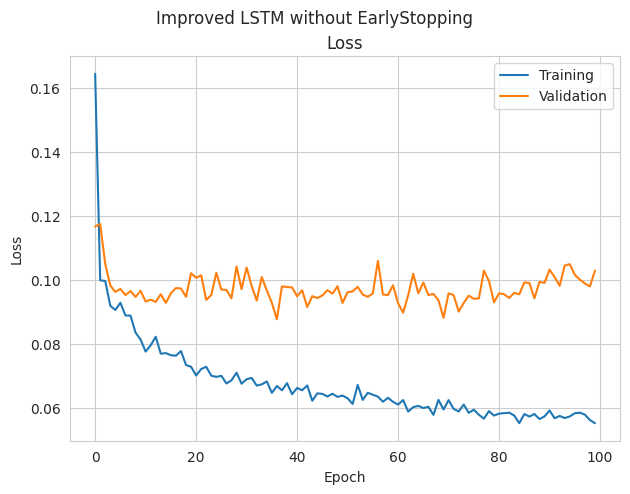

In [71]:
K.clear_session()

# Input and output for all models with two variables
n_features = output_size = 2

# Define model
model_LSTM_imp_no_ES = Sequential()
model_LSTM_imp_no_ES.add(tf.keras.layers.Input(shape=(6,n_features)))
model_LSTM_imp_no_ES.add(tf.keras.layers.LSTM(units=24, 
                                        dropout=0.1,
                                        recurrent_dropout=0.1,
                                        return_sequences=False))
model_LSTM_imp_no_ES.add(tf.keras.layers.Lambda(siren_activation))
model_LSTM_imp_no_ES.add(tf.keras.layers.Dense(units=12, activation="relu"))
model_LSTM_imp_no_ES.add(tf.keras.layers.Dense(units=output_size, activation="linear"))

# Compile
model_LSTM_imp_no_ES.compile(optimizer="RMSProp", loss="mae")
model_LSTM_imp_no_ES.summary()

start = time.time()
# Training

history_model_LSTM_imp_no_ES = model_LSTM_imp_no_ES.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=20,
    shuffle=False,
    validation_data=(X_test, y_test))

print("Training time: "+str(time.time()-start)+" seconds")

loss_acc_plot(history_model_LSTM_imp_no_ES, "Improved LSTM without EarlyStopping")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Text(0.5, 1.08, 'Real and predicted values with improved LSTM without EarlyStopping')

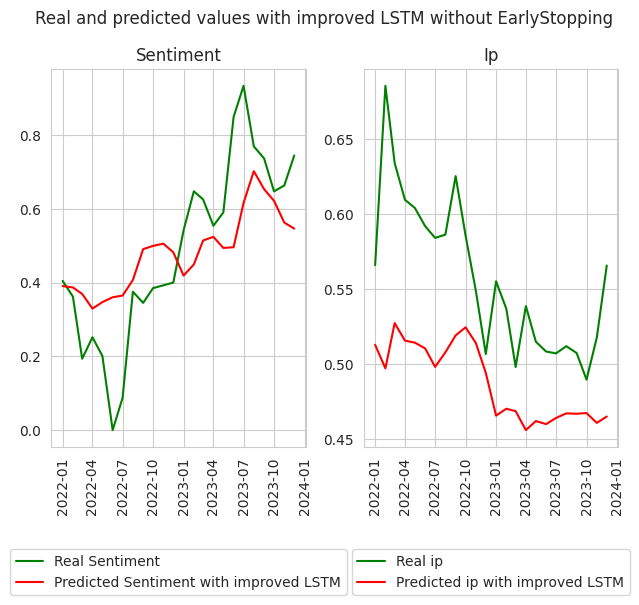

In [72]:
# Predict 
predict_LSTM_imp_no_ES = model_LSTM_imp_no_ES.predict(X_test)

# Add predictions of improved LSTM without EarlyStopping
df_test_more_patience["LSTM_imp_sentiment"] = predict_LSTM_imp_no_ES[:,0]
df_test_more_patience["LSTM_imp_ip"] = predict_LSTM_imp_no_ES[:,1]

# Show comparison
fig, ax = plt.subplots(1,2)
fig.tight_layout()
ax[0].plot(df_test_more_patience["min-max_sentiment"], color="green", label="Real Sentiment")
ax[0].plot(df_test_more_patience["LSTM_imp_sentiment"], color="red", label="Predicted Sentiment with improved LSTM")
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title("Sentiment")
box0 = ax[0].get_position()
ax[0].set_position([box0.x0, box0.y0 + box0.height * 0.1,
                    box0.width, box0.height * 0.9])
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

ax[1].plot(df_test_more_patience["min-max_ip"], color="green", label="Real ip")
ax[1].plot(df_test_more_patience["LSTM_imp_ip"], color="red", label="Predicted ip with improved LSTM")
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title("Ip")
box1 = ax[1].get_position()
ax[1].set_position([box1.x0, box1.y0 + box1.height * 0.1,
                    box1.width, box1.height * 0.9])
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

fig.suptitle("Real and predicted values with improved LSTM without EarlyStopping", y=1.08)

We see that, while not a perfect result, it significantly improves compared to the prediction for the two variables with the EarlyStopping callback.

## 7. Hiperparametrization 
We will now try to find better parameters for training the NNs using Optuna. With this framework, we will try to find the best values for the following parameters: *number of LSTM units*, *number of units in the dense layer*, *dropout rate*, *activation function*, *w0* and *b*.

In [73]:
import optuna

In [74]:
def create_model(trial):
    # Hiperparametrization parameters 
    units_LSTM = trial.suggest_int("units_lstm", 6, 48)
    units_dense = trial.suggest_int("units_dense", 6, 48)
    dropout_rate = trial.suggest_float("dropout_rate", 0,0.2, step=0.04)
    activation = trial.suggest_categorical("activation", ["relu", "siren"])
    w0 = trial.suggest_float("w0", 1, 5, step=0.2)
    b = trial.suggest_float("b", -1, 1, step=0.1)
    
    model = Sequential()
    model.add(tf.keras.layers.Input(shape=(6,2)))
    model.add(tf.keras.layers.LSTM(units=units_LSTM, 
                                   dropout=dropout_rate,
                                   recurrent_dropout=dropout_rate,
                                   return_sequences=False))

    if activation=="relu":
        pass
    else:
        model.add(tf.keras.layers.Lambda(siren_activation, arguments={'w0':w0, 'b':b}))
        
    model.add(tf.keras.layers.Dense(units=units_dense,activation="relu"))
    model.add(tf.keras.layers.Dense(units=2, activation="linear"))
    
    model.compile(optimizer="RMSProp", loss="mae")
    return model

In [75]:
# Objective function

def objective(trial):
    model = create_model(trial)
    patience = trial.suggest_int("patience", 10, 100, step=10)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience)
    
    history = model.fit(
        x=X_train,
        y=y_train,epochs=100,
        batch_size=20,
        callbacks=[early_stopping],
        shuffle=False,
        validation_data=(X_test, y_test),
        verbose=0)
    
    min_val_loss = np.min(history.history["val_loss"])
    
    return min_val_loss

In [76]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2024-12-15 12:00:29,669] A new study created in memory with name: no-name-c938c800-1379-461e-9f4d-33dd99350702
[I 2024-12-15 12:00:37,713] Trial 0 finished with value: 0.09855286031961441 and parameters: {'units_lstm': 33, 'units_dense': 13, 'dropout_rate': 0.16, 'activation': 'siren', 'w0': 4.800000000000001, 'b': -0.7, 'patience': 10}. Best is trial 0 with value: 0.09855286031961441.
[I 2024-12-15 12:01:02,019] Trial 1 finished with value: 0.08322305232286453 and parameters: {'units_lstm': 43, 'units_dense': 23, 'dropout_rate': 0.16, 'activation': 'siren', 'w0': 3.2, 'b': 0.5, 'patience': 70}. Best is trial 1 with value: 0.08322305232286453.
[I 2024-12-15 12:01:13,458] Trial 2 finished with value: 0.06318001449108124 and parameters: {'units_lstm': 23, 'units_dense': 24, 'dropout_rate': 0.0, 'activation': 'relu', 'w0': 2.6, 'b': -0.8, 'patience': 70}. Best is trial 2 with value: 0.06318001449108124.
[I 2024-12-15 12:01:24,547] Trial 3 finished with value: 0.06418439000844955 and pa

These are the best parameters found:

In [77]:
# Best parameters
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Parameters: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value:  0.051926881074905396
  Parameters: 
    units_lstm: 44
    units_dense: 11
    dropout_rate: 0.0
    activation: siren
    w0: 3.4000000000000004
    b: 0.20000000000000018
    patience: 100


## 8. Training with the best parameters

Once we have found the best parameters, let´s implement the model again:

In [78]:
K.clear_session()
# Create model, compile

model_optimized = Sequential()
model_optimized.add(tf.keras.layers.Input(shape=(6,2)))
model_optimized.add(tf.keras.layers.LSTM(units=trial.params["units_lstm"],
                               dropout=trial.params["dropout_rate"],
                               recurrent_dropout=trial.params["dropout_rate"],
                               return_sequences=False))
if trial.params["activation"] == "relu":
    pass
else:
    model_optimized.add(tf.keras.layers.Lambda(siren_activation, 
                                               arguments={'w0':trial.params["w0"],
                                                          'b':trial.params["b"]}))
model_optimized.add(tf.keras.layers.Dense(units=trial.params["units_dense"], activation="relu"))
model_optimized.add(tf.keras.layers.Dense(units=2, activation="linear"))

model_optimized.compile(optimizer="RMSProp", loss="mae")
model_optimized.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 44)             │         8,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 44)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 11)             │           495 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            24 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,791 (34.34 KB)

 Trainable params: 8,791 (34.34 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
start = time.time()
# Training

# Callback for Early stopping
early_stopping_model_optimized = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=trial.params["patience"])

# Callback for Model checkpoint
checkpoint_filepath = Path(results_path, 'lstm_opt.h5.keras')

model_checkpoint_model_optimized = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_loss",
    save_best_only=True)

# Entrenar el modelo
history_model_optimized = model_optimized.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=20,
    callbacks=[early_stopping_model_optimized, model_checkpoint_model_optimized],
    shuffle=False,
    validation_data=(X_test, y_test))

print("Training time: "+str(time.time()-start)+" seconds")

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3699 - val_loss: 0.1781
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1086 - val_loss: 0.1311
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0834 - val_loss: 0.1295
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0804 - val_loss: 0.1264
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0784 - val_loss: 0.1217
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0763 - val_loss: 0.1203
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0749 - val_loss: 0.1183
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0743 - val_loss: 0.1070
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0712 - val_loss: 0.1307
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0727 - val_loss: 0.1284
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0731 - val_loss: 0.1150
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

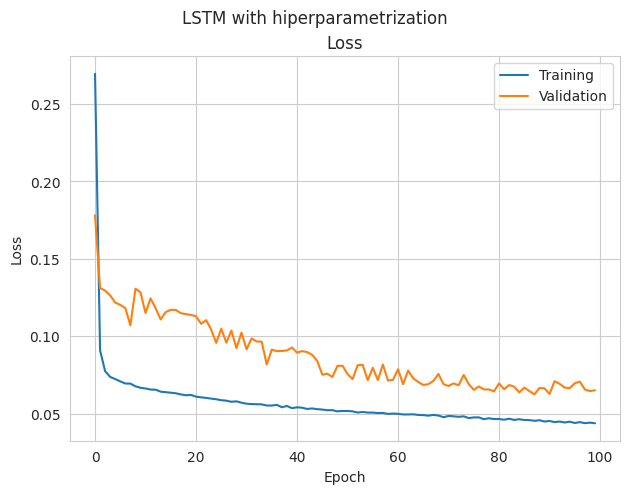

In [80]:
loss_acc_plot(history_model_optimized, "LSTM with hiperparametrization")

In [81]:
# Predict
predict_optimized = model_optimized.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


In [82]:
# Add predictions from optimized LSTM
df_test["optimized_sentiment"] = predict_optimized[:,0]
df_test["optimized_ip"] = predict_optimized[:,1]

Text(0.5, 1.08, 'Real and predicted values with optimized LSTM')

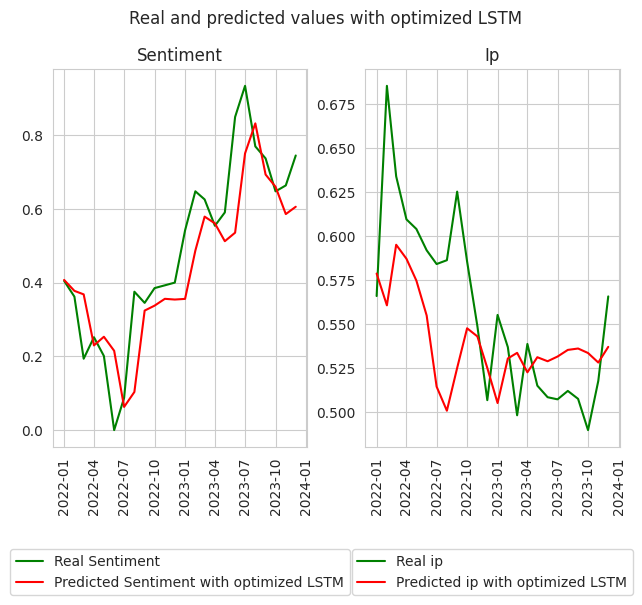

In [83]:
# Show comparison
fig, ax = plt.subplots(1,2)
fig.tight_layout()
ax[0].plot(df_test["min-max_sentiment"], color="green", label="Real Sentiment")
ax[0].plot(df_test["optimized_sentiment"], color="red", label="Predicted Sentiment with optimized LSTM")
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title("Sentiment")
box0 = ax[0].get_position()
ax[0].set_position([box0.x0, box0.y0 + box0.height * 0.1,
                    box0.width, box0.height * 0.9])
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

ax[1].plot(df_test["min-max_ip"], color="green", label="Real ip")
ax[1].plot(df_test["optimized_ip"], color="red", label="Predicted ip with optimized LSTM")
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title("Ip")
box1 = ax[1].get_position()
ax[1].set_position([box1.x0, box1.y0 + box1.height * 0.1,
                    box1.width, box1.height * 0.9])
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

fig.suptitle("Real and predicted values with optimized LSTM", y=1.08)

We have achieved a much better result than in previous models, indicating that hyperparameter tuning has worked well. As a side note, it's worth mentioning that something not explored in practice is increasing the number of LSTM layers (i.e., making the network deeper). Perhaps the number of values in the time series is somewhat limited, but it might be worth observing the effect. On the other hand, we clearly see a one-time-unit delay between the predicted and actual values. It would be interesting, as mentioned in the forum, to explore the effect of adding noise to the signal—perhaps this delay would disappear.

## 9. Model evaluation

Let's suppose we now have this previous model running in a company's production environment. Four months pass, and we want to evaluate how our optimized model predicts this new data. We will now load the data, perform the necessary transformations, and evaluate the model.

In [84]:
# Dataset loading until April 2024
df = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '1980', '2024-04').dropna()
df.columns = ['sentiment', 'ip']
df.head()

,sentiment,ip
DATE,,
1980-01-01,67.0,45.8562
1980-02-01,66.9,46.9435
1980-03-01,56.5,47.5013
1980-04-01,52.7,46.1175
1980-05-01,51.7,44.7997


In [85]:
# Checck NA for Sentiment
df.loc[df["sentiment"].isnull()==True]

,sentiment,ip
DATE,,


In [86]:
# Checck NA for ip
df.loc[df["ip"].isnull()==True]

,sentiment,ip
DATE,,


In [87]:
# Set the number of months for which we want to obtain the difference (1 year).
periods = 12

# Obtain the logarithm of each value and calculate the 12-month difference.
df["diff_log_sentiment"] = np.log(df["sentiment"]).diff(periods=periods)
df["diff_log_ip"] = np.log(df["ip"]).diff(periods=periods)

# Min-max scaling
max_sentiment = df["diff_log_sentiment"].max()
min_sentiment = df["diff_log_sentiment"].min()

max_ip = df["diff_log_ip"].max()
min_ip = df["diff_log_ip"].min()

df["min-max_sentiment"] = (df["diff_log_sentiment"] - min_sentiment) / (max_sentiment - min_sentiment)
df["min-max_ip"] = (df["diff_log_ip"] - min_ip) / (max_ip - min_ip)

Text(0.5, 1.0, 'min-max scaling')

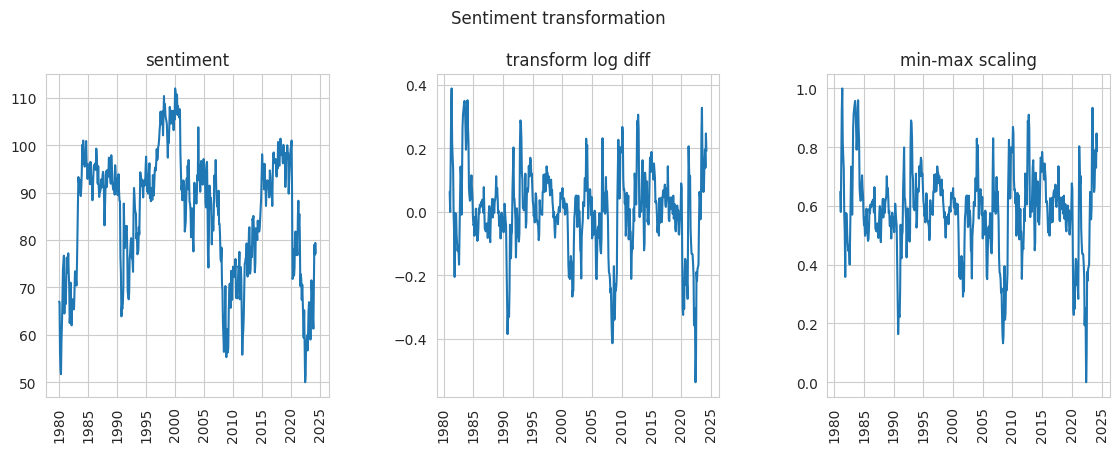

In [88]:
# Show original Sentiment variable and its transformations 

fig, ax = plt.subplots(1, 3)
fig.suptitle("Sentiment transformation", y=1.05)
fig.tight_layout()
fig.set_size_inches(12, 4)
ax[0].plot(df["sentiment"])
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title("sentiment")

ax[1].plot(df["diff_log_sentiment"])
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title("transform log diff")

ax[2].plot(df["min-max_sentiment"])
ax[2].tick_params(axis='x', rotation=90)
ax[2].set_title("min-max scaling")

Text(0.5, 1.0, 'min-max scaling')

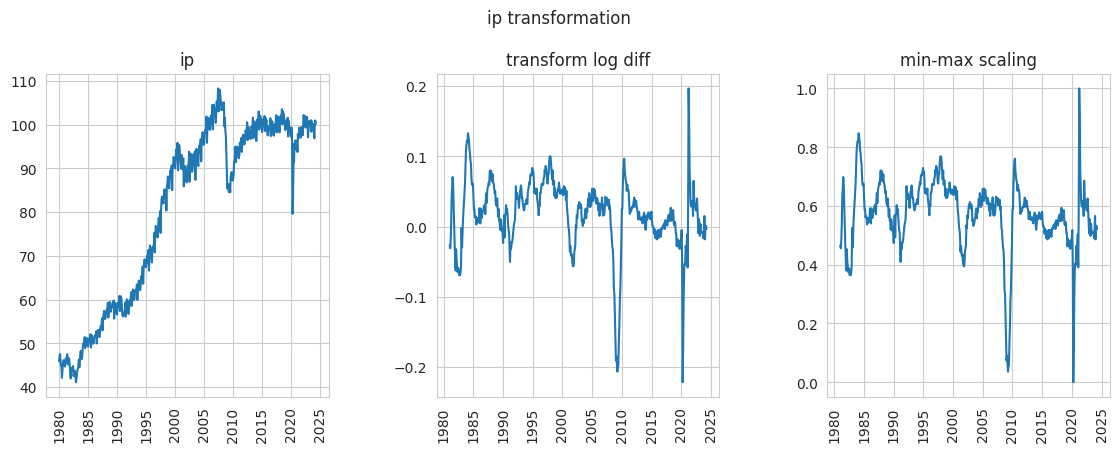

In [89]:
# Show original ip variable and its transformations 

fig, ax = plt.subplots(1, 3)
fig.suptitle("ip transformation", y=1.05)
fig.tight_layout()
fig.set_size_inches(12, 4)
ax[0].plot(df["ip"])
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title("ip")

ax[1].plot(df["diff_log_ip"])
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title("transform log diff")

ax[2].plot(df["min-max_ip"])
ax[2].tick_params(axis='x', rotation=90)
ax[2].set_title("min-max scaling")

In [90]:
# Finally, we keep only the transformed data.

# Additionally, since the 12-month difference cannot be applied to the first 12 rows (because we don't have data before 1980), these 12 rows will remain as NaN. Therefore, we remove them.

df = df[["min-max_sentiment", "min-max_ip"]].dropna()

In [91]:
df.tail()

,min-max_sentiment,min-max_ip
DATE,,
2023-12-01,0.745038,0.565738
2024-01-01,0.791927,0.486489
2024-02-01,0.730036,0.522295
2024-03-01,0.846765,0.532440
2024-04-01,0.787190,0.521205


In [92]:
# Set window_size
window_size = 6

# Create variables to store sequences and tags
X = []
y = []

# Call the function to extract sequences and tags
X, y = create_multivariate_rnn_data(df, window_size)

# Convert lists in arrays to feed the NNs 
X = np.array(X)
y = np.array(y)

In [93]:
# Separate data in training and test
# The training set includes all the labels except for the last 4, as well as the sequences (X) needed to predict those labels.

# The test set includes the last 4 labels, as well as the sequences (X) needed to predict those labels.

X_train = X[0:-4]
X_test = X[-4:]

y_train = y[0:-4]
y_test = y[-4:]

In [94]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(510, 6, 2)
(510, 2)
(4, 6, 2)
(4, 2)


In [95]:
K.clear_session()

# Load the model
modelo_opt_loaded = load_model(checkpoint_filepath, custom_objects=None, compile=True, safe_mode=True)

In [96]:
modelo_opt_loaded.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 44)             │         8,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 44)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 11)             │           495 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            24 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,584 (68.69 KB)

 Trainable params: 8,791 (34.34 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,793 (34.35 KB)

In [97]:
start = time.time()
# Training

# Callback for Early stopping
early_stopping_model_optimized = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=60)

# Training
history_modelo_opt_loaded = modelo_opt_loaded.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=20,
    callbacks=[early_stopping_model_optimized],
    shuffle=False,
    validation_data=(X_test, y_test))

print("Training time: "+str(time.time()-start)+" seconds")

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0489 - val_loss: 0.0385
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0482 - val_loss: 0.0403
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0493 - val_loss: 0.0386
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0482 - val_loss: 0.0388
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0485 - val_loss: 0.0392
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0475 - val_loss: 0.0396
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0476 - val_loss: 0.0400
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0468 - val_loss: 0.0406
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0476 - val_loss: 0.0401
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0466 - val_loss: 0.0402
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0470 - val_loss: 0.0406
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

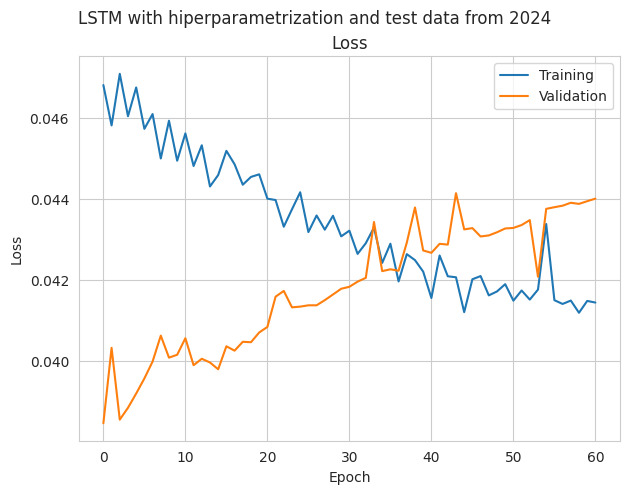

In [98]:
loss_acc_plot(history_modelo_opt_loaded, "LSTM with hiperparametrization and test data from 2024")

In [99]:
# Predict 
predict_modelo_opt_loaded = modelo_opt_loaded.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


In [100]:
# Subset last 4 rows of the dataset
df_test_prod =  df.iloc[-4:]

# Add LSTM predictions
df_test_prod["optimized_sentiment_loaded"] = predict_modelo_opt_loaded[:,0]
df_test_prod["optimized_ip_loaded"] = predict_modelo_opt_loaded[:,1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0440


Text(0.5, 1.1, 'Real and predicted values for optimized LSTM (loaded model) and data from 2024\nloss: 0.044')

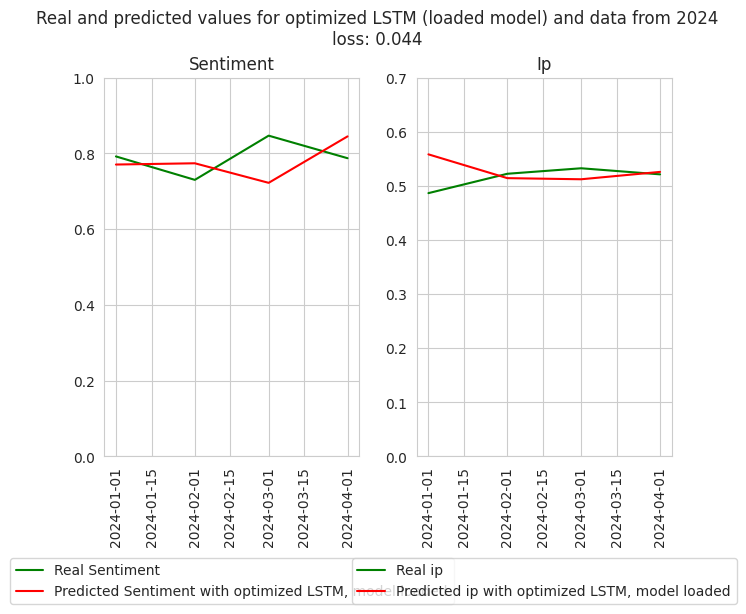

In [101]:
# Show comparison
fig, ax = plt.subplots(1,2)
fig.tight_layout()
ax[0].plot(df_test_prod["min-max_sentiment"], color="green", label="Real Sentiment")
ax[0].plot(df_test_prod["optimized_sentiment_loaded"], color="red", label="Predicted Sentiment with optimized LSTM, model loaded")
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title("Sentiment")
box0 = ax[0].get_position()
ax[0].set_position([box0.x0, box0.y0 + box0.height * 0.1,
                    box0.width, box0.height * 0.9])
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))
ax[0].set_ylim(0,1)

ax[1].plot(df_test_prod["min-max_ip"], color="green", label="Real ip")
ax[1].plot(df_test_prod["optimized_ip_loaded"], color="red", label="Predicted ip with optimized LSTM, model loaded")
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title("Ip")
box1 = ax[1].get_position()
ax[1].set_position([box1.x0, box1.y0 + box1.height * 0.1,
                    box1.width, box1.height * 0.9])
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))
ax[1].set_ylim(0,0.7)

fig.suptitle("Real and predicted values for optimized LSTM (loaded model) and data from 2024\n"\
    "loss: " + str(round(modelo_opt_loaded.evaluate(X_test, y_test),4)), y=1.10)

At first glance, it seems that the prediction fits well with the data (note that a similar scale to the other plots has been used). 